In [44]:
import jax.numpy as jnp
from jax import vmap
from functools import partial
import itertools
import matplotlib.pyplot as plt

In [45]:
# True solution
def fp_sol(x,t):
    K = 2*(1-jnp.exp(-2*t))
    return 1/(K*jnp.pi)*jnp.exp(-(jnp.sum(x**2))/K)

fp_sol = vmap(fp_sol,in_axes=(0,None)) # vmap'ed

In [46]:
# Data
x_train = jnp.linspace(-1,1,50)
y_train = fp_sol(x_train.reshape(-1,1),0.1)

x_test = jnp.linspace(-4,4,100)
y_test = fp_sol(x_test.reshape(-1,1),0.1)

In [52]:


def gaussian_kernel(x, x_train, bandwidth):
    return jnp.exp(-0.5 * ((x - x_train) / bandwidth) ** 2)

def nadaraya_watson_predict(x_query, x_train, y_train, bandwidth):
    def predict_one(xq):
        weights = gaussian_kernel(xq, x_train, bandwidth)
        weighted_sum = jnp.sum(weights * y_train)
        normalizer = jnp.sum(weights)
        return weighted_sum / normalizer
    return vmap(predict_one)(x_query)

def mean_squared_error(y_true, y_pred):
    return jnp.mean((y_true - y_pred) ** 2)

def k_fold_split(x, y, k):
    n = len(x)
    idx = jnp.arange(n)
    folds = jnp.array_split(idx, k)
    for i in range(k):
        val_idx = folds[i]
        train_idx = jnp.concatenate([folds[j] for j in range(k) if j != i])
        yield x[train_idx], y[train_idx], x[val_idx], y[val_idx]

def cross_validate_bandwidth(x, y, bandwidths, k=5):
    def cv_loss(bw):
        def fold_loss(x_train, y_train, x_val, y_val):
            y_pred = nadaraya_watson_predict(x_val, x_train, y_train, bw)
            return mean_squared_error(y_val, y_pred)
        
        losses = []
        for x_train, y_train, x_val, y_val in k_fold_split(x, y, k):
            loss = fold_loss(x_train, y_train, x_val, y_val)
            losses.append(loss)
        return jnp.mean(jnp.array(losses))
    
    losses = jnp.array([cv_loss(bw) for bw in bandwidths])
    best_idx = jnp.argmin(losses)
    return bandwidths[best_idx], losses[best_idx]

In [48]:
bandwidths = jnp.linspace(0.01, 0.2, 40)
best_bw, best_loss = cross_validate_bandwidth(x_train, y_train, bandwidths, k=3)

In [49]:
best_bw

Array(0.01, dtype=float32)

In [50]:
y_pred = nadaraya_watson_predict(x_test,x_train,y_train,bandwidth=best_bw)

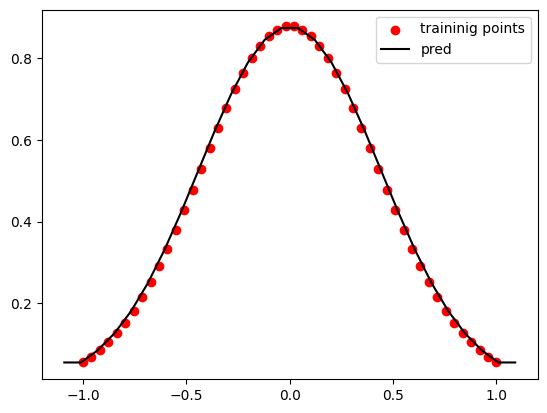

In [51]:
plt.scatter(x_train, y_train,
            c = 'red',
            label = 'traininig points')
plt.plot(x_test,y_pred,
         c = 'black',
         label = 'pred')
plt.legend()
plt.show()

# Estimator

Given data $(X,y)$. The NW estimator is given by:

$$
\hat u(x) = \frac{1}{\sum_{i=1}^N K(x,x_i)} K(x,X)^\top y
$$

# Does it interpolate the data?

$$
\hat u(x_i) = \frac{1}{\sum_{j=1}^N K(x_i,x_j)} K(x_i,X)^\top y \neq y_i
$$
No.

## Bounded linear functional of this ?

$$
\partial_x(\hat u)(x) = \partial_x \left(\frac{1}{\sum_{j=1}^N K(x_i,x_j)} K(x_i,X)^\top y \neq y_i\right)
$$